# The Map of Hodographs
Creator: Cameron J. Nixon

In [1]:
# Imports software
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
import scipy.ndimage as ndimage
from datetime import datetime, timedelta
from netCDF4 import num2date
from siphon.ncss import NCSS
from siphon.catalog import TDSCatalog
import metpy.calc as mpcalc
from metpy.units import units

In [2]:
method = 'reanalysis'
# method = 'realtime'

if (method == 'reanalysis'):
    # Choose date
    year  = '2013'
    month = '11'
    day   = '17'
    hour  = '1700' # 0000-2300
    fcst  = '000' # 000
    # Choose center latitude/longitude
    center_lat = 40.69
    center_lon = -89.37

elif (method == 'realtime'):
    forecast_hour = 2
    center_lat = 35.18
    center_lon = -97.44
    
# Choose domain
domain = 'state'

# Choose relativity
relativity = 'ground' # ground/storm

# Form Domain
if domain == 'local':
    north_lat = center_lat + 2.33
    south_lat = center_lat - 2.33
    west_lon = center_lon - 3.305
    east_lon = center_lon + 3.305
elif domain == 'state':
    north_lat = center_lat + 3.3
    south_lat = center_lat - 3.3
    west_lon = center_lon - 4.67
    east_lon = center_lon + 4.67
elif domain == 'sub-regional':
    north_lat = center_lat + 4.155
    south_lat = center_lat - 4.155
    west_lon = center_lon - 5.875
    east_lon = center_lon + 5.875
elif domain == 'regional':
    north_lat = center_lat + 5.75
    south_lat = center_lat - 5.75
    west_lon = center_lon - 8.125
    east_lon = center_lon + 8.125
elif domain == 'plains': 
    north_lat = center_lat + 9
    south_lat = center_lat - 9
    west_lon = center_lon - 6.2
    east_lon = center_lon + 6.2
#Default center: 39.20, -100.00
elif domain == 'full': 
    north_lat = center_lat + 8.5
    south_lat = center_lat - 8.5
    west_lon = center_lon - 12
    east_lon = center_lon + 12
#Default center: 39.20, -94.70
else:
    north_lat = center_lat + 8.5
    south_lat = center_lat - 8.5
    west_lon = center_lon - 12
    east_lon = center_lon + 12
#Default center: 39.20, -94.70

# Analysis Resolution
res = 2

In [3]:
# Reanalysis
if (method == 'reanalysis'):
    for attempt in range(50):
        try:
            # Downloads RAP data
            try:
                data = NCSS('https://www.ncei.noaa.gov/thredds/ncss/model-rap130anl/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/rap_130_'+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+'.grb2')
            except:
                data = NCSS('https://www.ncdc.noaa.gov/thredds/ncss/model-rap130anl-old/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/rap_130_'+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+'.grb2')
            # Initiates query
            query = data.query()
            # Subsets by data
            query.variables('MSLP_MAPS_System_Reduction_msl',
                            'Pressure_surface',
                            'Geopotential_height_isobaric',
                            'Geopotential_height_surface',
                            'Temperature_isobaric',
                            'Relative_humidity_isobaric',
                            'Temperature_height_above_ground',
                            'Relative_humidity_height_above_ground',
                            'Dewpoint_temperature_height_above_ground',
                            'u-component_of_wind_height_above_ground', 'v-component_of_wind_height_above_ground', 
                            'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric', 
                            'Convective_available_potential_energy_surface',
                            'Storm_relative_helicity_height_above_ground_layer',
                            ).add_lonlat()
            # Subsets by area
            query.lonlat_box(west_lon,east_lon,south_lat,north_lat)
            # Gets data
            data_RAP = data.get_data(query)
                
            # Defines data
            mslp   = data_RAP.variables['MSLP_MAPS_System_Reduction_msl'][0,:,:]/100
            mslps  = data_RAP.variables['Pressure_surface'][0,:,:]/100
            hght   = data_RAP.variables['Geopotential_height_isobaric'][0,:,:,:]
            hghts  = data_RAP.variables['Geopotential_height_surface'][0,:,:]
            relh   = data_RAP.variables['Relative_humidity_isobaric'][0,:,:,:]
            tmps   = data_RAP.variables['Temperature_height_above_ground'][0,0,:,:]
            dwps   = data_RAP.variables['Dewpoint_temperature_height_above_ground'][0,0,:,:]
            relhs  = data_RAP.variables['Relative_humidity_height_above_ground'][0,0,:,:]
            uwnd   = data_RAP.variables['u-component_of_wind_height_above_ground'][0,0,:,:]*1.94384
            vwnd   = data_RAP.variables['v-component_of_wind_height_above_ground'][0,0,:,:]*1.94384
            uwndp  = data_RAP.variables['u-component_of_wind_isobaric'][0,:,:,:]*1.94384
            vwndp  = data_RAP.variables['v-component_of_wind_isobaric'][0,:,:,:]*1.94384
            cape   = data_RAP.variables['Convective_available_potential_energy_surface'][0,:,:]
            srh1   = ndimage.gaussian_filter(data_RAP.variables['Storm_relative_helicity_height_above_ground_layer'][0,0,:,:],sigma=0.75)
            srh3   = ndimage.gaussian_filter(data_RAP.variables['Storm_relative_helicity_height_above_ground_layer'][0,1,:,:],sigma=0.75)
            
            # Gets name of dimension
            dtime = data_RAP.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[0]
            dlat = data_RAP.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[1]
            dlon = data_RAP.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[2]
            # Gets dimension data
            lat = 1000*(data_RAP.variables[dlat][:])
            lon = 1000*(data_RAP.variables[dlon][:])
            time = data_RAP.variables[dtime]
                
            # Gets number of latitude/longitude points
            latnum = lat.shape[0]
            lonnum = lon.shape[0]
            # Set up times
            vtimes = num2date(time[:],time.units)
            
            data_RAP.close()
            
            model = 'RAP'
            gridspace = 13000 # meters
            vertlevels = 37
                
        except:
            try:   
                # Downloads RUC data
                try:
                    data = NCSS('https://www.ncei.noaa.gov/thredds/ncss/model-ruc130anl/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/ruc2anl_130_'+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+'.grb2')
                except:
                    data = NCSS('https://www.ncei.noaa.gov/thredds/ncss/model-ruc130anl-old/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/ruc2anl_130_'+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+'.grb2')
                # Initiates query
                query = data.query()
                # Subsets by data
                query.variables('MSLP_MAPS_System_Reduction_msl',
                                'Pressure_surface',
                                'Geopotential_height_isobaric',
                                'Geopotential_height_surface',
                                'Temperature_isobaric',
                                'Relative_humidity_isobaric',
                                'Temperature_height_above_ground',
                                'Dewpoint_temperature_height_above_ground',
                                'Relative_humidity_height_above_ground',
                                'u-component_of_wind_height_above_ground', 'v-component_of_wind_height_above_ground', 
                                'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric', 
                                'Convective_available_potential_energy_surface',
                                'Storm_relative_helicity_height_above_ground_layer',
                                ).add_lonlat()
                # Subsets by area
                query.lonlat_box(west_lon,east_lon,south_lat,north_lat)
                # Gets data
                data_RUC = data.get_data(query)
                
                # Defines data
                mslp   = data_RUC.variables['MSLP_MAPS_System_Reduction_msl'][0,:,:]/100
                mslps  = data_RUC.variables['Pressure_surface'][0,:,:]/100
                hght   = data_RUC.variables['Geopotential_height_isobaric'][0,:,:,:]
                hghts  = data_RUC.variables['Geopotential_height_surface'][0,:,:]
                uwnd   = data_RUC.variables['u-component_of_wind_height_above_ground'][0,0,:,:]*1.94384
                vwnd   = data_RUC.variables['v-component_of_wind_height_above_ground'][0,0,:,:]*1.94384
                uwndp  = data_RUC.variables['u-component_of_wind_isobaric'][0,:,:,:]*1.94384
                vwndp  = data_RUC.variables['v-component_of_wind_isobaric'][0,:,:,:]*1.94384
                cape   = data_RUC.variables['Convective_available_potential_energy_surface'][0,:,:]
                srh3   = ndimage.gaussian_filter(data_RUC.variables['Storm_relative_helicity_height_above_ground_layer'][0,0,:,:],sigma=0.75)
                
                # Gets name of dimension
                dtime = data_RUC.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[0]
                dlat = data_RUC.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[1]
                dlon = data_RUC.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[2]
                # Gets dimension data
                lat = 1000*(data_RUC.variables[dlat][:])
                lon = 1000*(data_RUC.variables[dlon][:])
                time = data_RUC.variables[dtime]
                
                # Gets number of latitude/longitude points
                latnum = lat.shape[0]
                lonnum = lon.shape[0]
                # Set up times
                vtimes = num2date(time[:],time.units)
                
                data_RUC.close()
                
                model = 'RUC'
                gridspace = 13000 # meters
                vertlevels = 37
            
            except:
                try:
                    # Downloads RAP data
                    try:
                        data = NCSS('https://www.ncei.noaa.gov/thredds/ncss/model-rap252anl/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/rap_252_'+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+'.grb2')
                    except:
                        data = NCSS('https://www.ncei.noaa.gov/thredds/ncss/model-rap252anl-old/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/rap_252_'+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+'.grb2')
                    # Initiates query
                    query = data.query()
                    # Subsets by data
                    query.variables('MSLP_MAPS_System_Reduction_msl',
                                    'Pressure_surface',
                                    'Geopotential_height_isobaric',
                                    'Geopotential_height_surface',
                                    'Temperature_isobaric',
                                    'Relative_humidity_isobaric',
                                    'Temperature_height_above_ground',
                                    'Dewpoint_temperature_height_above_ground',
                                    'Relative_humidity_height_above_ground',
                                    'u-component_of_wind_height_above_ground', 'v-component_of_wind_height_above_ground', 
                                    'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric', 
                                    'Convective_available_potential_energy_surface',
                                    'Storm_relative_helicity_height_above_ground_layer',
                                    ).add_lonlat()
                    # Subsets by area
                    query.lonlat_box(west_lon,east_lon,south_lat,north_lat)
                    # Gets data
                    data_RAP = data.get_data(query)
                    
                    # Defines data
                    mslp   = data_RAP.variables['MSLP_MAPS_System_Reduction_msl'][0,:,:]/100
                    mslps  = data_RAP.variables['Pressure_surface'][0,:,:]/100
                    hght   = data_RAP.variables['Geopotential_height_isobaric'][0,:,:,:]
                    hghts  = data_RAP.variables['Geopotential_height_surface'][0,:,:]
                    uwnd   = data_RAP.variables['u-component_of_wind_height_above_ground'][0,0,:,:]*1.94384
                    vwnd   = data_RAP.variables['v-component_of_wind_height_above_ground'][0,0,:,:]*1.94384
                    uwndp  = data_RAP.variables['u-component_of_wind_isobaric'][0,:,:,:]*1.94384
                    vwndp  = data_RAP.variables['v-component_of_wind_isobaric'][0,:,:,:]*1.94384
                    cape   = data_RAP.variables['Convective_available_potential_energy_surface'][0,:,:]
                    srh1   = ndimage.gaussian_filter(data_RAP.variables['Storm_relative_helicity_height_above_ground_layer'][0,0,:,:],sigma=0.75)
                    srh3   = ndimage.gaussian_filter(data_RAP.variables['Storm_relative_helicity_height_above_ground_layer'][0,1,:,:],sigma=0.75)
                    
                    # Gets name of dimension
                    dtime = data_RAP.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[0]
                    dlat = data_RAP.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[1]
                    dlon = data_RAP.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[2]
                    # Gets dimension data
                    lat = 1000*(data_RAP.variables[dlat][:])
                    lon = 1000*(data_RAP.variables[dlon][:])
                    time = data_RAP.variables[dtime]
                    
                    # Gets number of latitude/longitude points
                    latnum = lat.shape[0]
                    lonnum = lon.shape[0]
                    # Set up times
                    vtimes = num2date(time[:],time.units)
                    
                    data_RAP.close()
                    
                    model = 'RAP'
                    gridspace = 20000 # meters
                    vertlevels = 37
                    
                except:
                    # Downloads RUC data
                    try:
                        data = NCSS('https://www.ncei.noaa.gov/thredds/ncss/model-ruc252anl/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/ruc2anl_252_'+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+'.grb')
                    except:
                        data = NCSS('https://www.ncei.noaa.gov/thredds/ncss/model-ruc252anl-old/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/ruc2anl_252_'+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+'.grb')
                    # Initiates query
                    query = data.query()
                    # Subsets by data
                    query.variables('Mean_Sea_Level_Pressure_MAPS_System_Reduction_msl',
                                    'Pressure_surface',
                                    'Geopotential_height_isobaric',
                                    'Geopotential_height_surface',
                                    'Temperature_isobaric',
                                    'Relative_humidity_isobaric',
                                    'Temperature_height_above_ground',
                                    'Dew_point_temperature_height_above_ground',
                                    'Relative_humidity_height_above_ground',
                                    'u-component_of_wind_height_above_ground', 'v-component_of_wind_height_above_ground', 
                                    'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric', 
                                    'Convective_Available_Potential_Energy_surface',
                                    'Storm_relative_helicity_surface',
                                    ).add_lonlat()
                    # Subsets by area
                    query.lonlat_box(west_lon,east_lon,south_lat,north_lat)
                    # Gets data
                    data_RUC = data.get_data(query)
                    
                    # Defines data
                    mslp   = data_RUC.variables['Mean_Sea_Level_Pressure_MAPS_System_Reduction_msl'][0,:,:]/100
                    mslps  = data_RUC.variables['Pressure_surface'][0,:,:]/100
                    hght   = data_RUC.variables['Geopotential_height_isobaric'][0,:,:,:]
                    hghts  = data_RUC.variables['Geopotential_height_surface'][0,:,:]
                    uwnd   = data_RUC.variables['u-component_of_wind_height_above_ground'][0,0,:,:]*1.94384
                    vwnd   = data_RUC.variables['v-component_of_wind_height_above_ground'][0,0,:,:]*1.94384
                    uwndp  = data_RUC.variables['u-component_of_wind_isobaric'][0,:,:,:]*1.94384
                    vwndp  = data_RUC.variables['v-component_of_wind_isobaric'][0,:,:,:]*1.94384
                    cape   = data_RUC.variables['Convective_Available_Potential_Energy_surface'][0,:,:]
                    srh3   = ndimage.gaussian_filter(data_RUC.variables['Storm_relative_helicity_surface'][0,:,:],sigma=0.75)
                    
                    # Gets name of dimension
                    dtime = data_RUC.variables['Mean_Sea_Level_Pressure_MAPS_System_Reduction_msl'].dimensions[0]
                    dlat = data_RUC.variables['Mean_Sea_Level_Pressure_MAPS_System_Reduction_msl'].dimensions[1]
                    dlon = data_RUC.variables['Mean_Sea_Level_Pressure_MAPS_System_Reduction_msl'].dimensions[2]
                    # Gets dimension data
                    lat = 1000*(data_RUC.variables[dlat][:])
                    lon = 1000*(data_RUC.variables[dlon][:])
                    time = data_RUC.variables[dtime]
                    
                    # Gets number of latitude/longitude points
                    latnum = lat.shape[0]
                    lonnum = lon.shape[0]
                    # Set up times
                    vtimes = num2date(time[:],time.units)
                    
                    data_RUC.close()
                    
                    model = 'RUC'
                    gridspace = 20000 # meter
                    vertlevels = 37
        else:
            break
    else:
        print('server error')
        
# Real-Time
elif (method == 'realtime'):
    # Downloads RAP data
    cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/RAP/CONUS_13km/latest.xml')
    latest_ds = list(cat.datasets.values())[0]
    ncss = NCSS(latest_ds.access_urls['NetcdfSubset'])
    # Initiates query
    query = ncss.query()
    # Find start time
    start_time = ncss.metadata.time_span['begin']
    start = datetime.strptime(start_time, '%Y-%m-%dT%H:%M:%SZ')
    fhour = start+timedelta(hours=forecast_hour)
    # Subsets by time
    query.time(fhour).accept('netcdf4')
    # Subsets by data
    query.variables('MSLP_MAPS_System_Reduction_msl',
                    'Pressure_surface',
                    'Geopotential_height_isobaric',
                    'Temperature_isobaric',
                    'Relative_humidity_isobaric',
                    'Temperature_height_above_ground',
                    'Relative_humidity_height_above_ground',
                    'u-component_of_wind_height_above_ground', 'v-component_of_wind_height_above_ground', 
                    'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric',
                    'Convective_available_potential_energy_surface'
                    )
    # Subsets by area
    query.add_lonlat().lonlat_box(west_lon,east_lon,south_lat,north_lat)
    # Gets data
    data_RAP = ncss.get_data(query)

    # Defines RAP data
    mslp   = data_RAP.variables['MSLP_MAPS_System_Reduction_msl'][0,:,:]/100
    mslps  = data_RAP.variables['Pressure_surface'][0,:,:]/100
    hght   = data_RAP.variables['Geopotential_height_isobaric'][0,:,:,:]
    uwnd   = data_RAP.variables['u-component_of_wind_height_above_ground'][0,0,:,:]*1.94384
    vwnd   = data_RAP.variables['v-component_of_wind_height_above_ground'][0,0,:,:]*1.94384
    uwndp  = data_RAP.variables['u-component_of_wind_isobaric'][0,:,:,:]*1.94384
    vwndp  = data_RAP.variables['v-component_of_wind_isobaric'][0,:,:,:]*1.94384
    cape   = data_RAP.variables['Convective_available_potential_energy_surface'][0,:,:]
    
    # Gets name of dimension
    dtime = data_RAP.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[0]
    dlat = data_RAP.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[1]
    dlon = data_RAP.variables['MSLP_MAPS_System_Reduction_msl'].dimensions[2]
    # Gets dimension data
    lat = 1000*(data_RAP.variables[dlat][:])
    lon = 1000*(data_RAP.variables[dlon][:])
    time = data_RAP.variables[dtime]
    # Gets number of latitude/longitude points
    latnum = lat.shape[0]
    lonnum = lon.shape[0]
    # Set up times
    vtimes = num2date(time[:],time.units)
    
    data_RAP.close()

    # Imports Surface Heights
    for attempt in range(50):
        try:
            # Choose date
            year  = '2016'
            month = '06'
            day   = '06'
            hour  = '0000' # 0000-2300
            fcst  = '000' # 000
            # Downloads RAP data
            data = NCSS('https://www.ncei.noaa.gov/thredds/ncss/model-rap130anl-old/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/rap_130_'+str(year)+str(month)+str(day)+'_'+str(hour)+'_'+str(fcst)+'.grb2')
            # Initiates query
            query = data.query()
            # Subsets by data
            query.variables(
                            'Geopotential_height_surface'
                            ).add_lonlat()
            # Subsets by area
            query.lonlat_box(west_lon,east_lon,south_lat,north_lat)
            # Gets data
            data_RAP = data.get_data(query)
            # Defines data
            hghts  = data_RAP.variables['Geopotential_height_surface'][0,:,:]
            data_RAP.close()
        except:
            print('failed attempt')
        else:
            break
    else:
        print('failed, corrupt data')
        #Gets heights array just in case NCDC archive fails
        hghts  = np.zeros((len(lat),len(lon)))
    
    model = 'RAP'
    gridspace = 13000 # meter
    vertlevels = 37

In [4]:
# Optimizes Data

"""
get_sfc_index

This function takes an array of height values and finds the index before the first positive value

Input: height_arr (array-like object of height values)

Output: index (int indicating the index just before the first positive height value. If -1 is returned,
               a positive index could not be found.)
"""

def get_sfc_index(height_arr):
    
    i = 0
    
    # Search the array for the sfc index
    while i < len(height_arr):
        if height_arr[i] >= 0:
            return i
            
        else:
            i += 1
            
    # Did not find a positive index
    return -1

# Creates Arrays for Vertical Profile

"""
make_sfc_based_3D

This function takes a 3D array of mandatory level data and a 2D array of surface data, 
appends the surface data onto the mandatory level array, and returns a single array
of both surface and mandatory level data

Inputs: arr (array-like object)

Output: mod_arr (numpy array)
"""

def make_sfc_based_3D(arr, sfc_arr):
    mod_arr = np.zeros((np.shape(arr)[0]+1,np.shape(arr)[1],np.shape(arr)[2]))
    for j in range(np.shape(arr)[1]):
        for k in range(np.shape(arr)[2]):
            mod_arr[0,j,k] = sfc_arr[j,k]
            mod_arr[1:,j,k] = arr[:,j,k]
    return mod_arr

# Finds Upper-level Values
p_i = [100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
p_i = p_i[::-1]
p = np.zeros((vertlevels,latnum,lonnum))
for j in range(latnum):
    for k in range(lonnum):
        p[:,j,k] = np.array(p_i) 
h = hght[::-1]-hghts
u = uwndp[::-1]
v = vwndp[::-1]

# Finds Surface Values
ps = mslps
hs = np.zeros((np.shape(h[:,:,:])[1],np.shape(h[:,:,:])[2]))
us = uwnd
vs = vwnd

# Zeros any value below the surface
for j in range(latnum):
    for k in range(lonnum):
        for i in range(vertlevels):
            if(h[i,j,k]<0):
                h[i,j,k] = 0.0
                p[i,j,k] = ps[j,k]
                u[i,j,k] = us[j,k]
                v[i,j,k] = vs[j,k]

# Creates Arrays for Vertical Profiles
h_new = make_sfc_based_3D(h,hs)
p_new = make_sfc_based_3D(p,ps)
u_new = make_sfc_based_3D(u,us)
v_new = make_sfc_based_3D(v,vs)

h = h_new
p = p_new
u = u_new
v = v_new

In [5]:
# Calculates Storm Motion
rightmover = np.zeros((2,latnum,lonnum))
leftmover = np.zeros((2,latnum,lonnum))
meanwind = np.zeros((2,latnum,lonnum))
for i in range(0,latnum,res):
    for j in range(0,lonnum,res):
        sfc_ind = np.where(h[:,i,j]==0.0)[0][-1]
        rightmover[:,i,j],leftmover[:,i,j],meanwind[:,i,j] = mpcalc.bunkers_storm_motion(p[sfc_ind:,i,j]*units('hPa'),u[sfc_ind:,i,j]*units('knot'),v[sfc_ind:,i,j]*units('knot'),h[sfc_ind:,i,j]*units('meter'))
rightmoveru = rightmover[0]
rightmoverv = rightmover[1]
leftmoveru = leftmover[0]
leftmoverv = leftmover[1]
meanwindu = meanwind[0]
meanwindv = meanwind[1]
    
if (relativity == 'storm'):
    # Calculates Storm-Relative Hodographs
    ur = u-rightmoveru
    vr = v-rightmoverv
else:
    ur = u
    vr = v

In [6]:
# Set up our projection
crs = ccrs.PlateCarree()
globe = ccrs.Globe(datum='WGS84',ellipse='sphere')

# Set up our array of latitude and longitude values and transform to 
# the desired projection.
clons, clats = np.meshgrid(lon, lat)
tlatlons = crs.transform_points(ccrs.LambertConformal(central_longitude=-95, central_latitude=25,standard_parallels=(25.,25.),globe=globe),clons,clats)
tlons = tlatlons[:,:,0]
tlats = tlatlons[:,:,1]

# Get data to plot state and county boundaries, roads
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lakes',
        scale='10m',
        facecolor='none')

# Hodograph Map

In [7]:
def plot_hodomap(u,v,rightmoveru,rightmoverv,tlons,tlats,ax,scaling=0.01,spacing=3):

    
    tlonscape = np.ma.masked_where(cape[:,:]<250, tlons)
    tlatscape = np.ma.masked_where(cape[:,:]<250, tlats)

    # Plot surface wind
    ax.barbs(tlons[::res,::res],tlats[::res,::res],uwnd[::res,::res],vwnd[::res,::res],color='grey',length=5.75,alpha=0.15,zorder=4.3)
    
    def find_nearest(array, value):
        '''
        Function to find index of the array in which the value is closest to
    
        Parameters: array (array), value (number)
        Returns: index (int)
    
        Example: xind = find_nearest(x,5)
        '''
    
        array = np.asarray(array)
        idx = (np.abs(array-value)).argmin()
        return idx
    
    # Plot hodographs  
    for i in range(0, latnum, res*spacing):
        for j in range(0, lonnum, res*spacing):
            if (cape[i,j]>=250):
                ring1 = plt.Circle([tlonscape[i,j],tlatscape[i,j]],20*scaling,color='black',linestyle='--',fill=False,alpha=0.075,zorder=4.22)
                ax.add_artist(ring1)
                
                ring2 = plt.Circle((tlonscape[i,j],tlatscape[i,j]),40*scaling,color='black',linestyle='--',fill=False,alpha=0.075,zorder=4.22)
                ax.add_artist(ring2)
            
                v0u = ur[0,i,j]*scaling
                v0v = vr[0,i,j]*scaling
                
                v025u = ur[:,i,j][find_nearest(h[:,i,j],250)]*scaling-v0u
                v025v = vr[:,i,j][find_nearest(h[:,i,j],250)]*scaling-v0v
        
                v05u = ur[:,i,j][find_nearest(h[:,i,j],500)]*scaling-v025u
                v05v = vr[:,i,j][find_nearest(h[:,i,j],500)]*scaling-v025v
    
                v1u = ur[:,i,j][find_nearest(h[:,i,j],1000)]*scaling-v05u
                v1v = vr[:,i,j][find_nearest(h[:,i,j],1000)]*scaling-v05v
                
                v15u = ur[:,i,j][find_nearest(h[:,i,j],1500)]*scaling-v1u
                v15v = vr[:,i,j][find_nearest(h[:,i,j],1500)]*scaling-v1v
                 
                v2u = ur[:,i,j][find_nearest(h[:,i,j],2000)]*scaling-v15u
                v2v = vr[:,i,j][find_nearest(h[:,i,j],2000)]*scaling-v15v
                
                v3u = ur[:,i,j][find_nearest(h[:,i,j],3000)]*scaling-v2u
                v3v = vr[:,i,j][find_nearest(h[:,i,j],3000)]*scaling-v2v
                
                v4u = ur[:,i,j][find_nearest(h[:,i,j],4000)]*scaling-v3u
                v4v = vr[:,i,j][find_nearest(h[:,i,j],4000)]*scaling-v3v
                
                v5u = ur[:,i,j][find_nearest(h[:,i,j],5000)]*scaling-v4u
                v5v = vr[:,i,j][find_nearest(h[:,i,j],5000)]*scaling-v4v
                
                v6u = ur[:,i,j][find_nearest(h[:,i,j],6000)]*scaling-v5u
                v6v = vr[:,i,j][find_nearest(h[:,i,j],6000)]*scaling-v5v
                
                v7u = ur[:,i,j][find_nearest(h[:,i,j],7000)]*scaling-v6u
                v7v = vr[:,i,j][find_nearest(h[:,i,j],7000)]*scaling-v6v
                    
                v8u = ur[:,i,j][find_nearest(h[:,i,j],8000)]*scaling-v7u
                v8v = vr[:,i,j][find_nearest(h[:,i,j],8000)]*scaling-v7v
                    
                v9u = ur[:,i,j][find_nearest(h[:,i,j],9000)]*scaling-v8u
                v9v = vr[:,i,j][find_nearest(h[:,i,j],9000)]*scaling-v8v
                
                ax.plot([tlonscape[i,j]+v5u+v6u,tlonscape[i,j]+v6u+v7u,tlonscape[i,j]+v7u+v8u,tlonscape[i,j]+v8u+v9u],[tlatscape[i,j]+v5v+v6v,tlatscape[i,j]+v6v+v7v,tlatscape[i,j]+v7v+v8v,tlatscape[i,j]+v8v+v9v],color='gold',linewidth=1.75)
                ax.plot([tlonscape[i,j]+v2u+v3u,tlonscape[i,j]+v3u+v4u,tlonscape[i,j]+v4u+v5u,tlonscape[i,j]+v5u+v6u],[tlatscape[i,j]+v2v+v3v,tlatscape[i,j]+v3v+v4v,tlatscape[i,j]+v4v+v5v,tlatscape[i,j]+v5v+v6v],color='darkorange',linewidth=1.75)
                ax.plot([tlonscape[i,j]+v05u+v1u,tlonscape[i,j]+v1u+v15u,tlonscape[i,j]+v15u+v2u,tlonscape[i,j]+v2u+v3u],[tlatscape[i,j]+v05v+v1v,tlatscape[i,j]+v1v+v15v,tlatscape[i,j]+v15v+v2v,tlatscape[i,j]+v2v+v3v],color='red',linewidth=1.75)
                ax.plot([tlonscape[i,j]+v0u,tlonscape[i,j]+v0u+v025u,tlonscape[i,j]+v025u+v05u,tlonscape[i,j]+v05u+v1u],[tlatscape[i,j]+v0v,tlatscape[i,j]+v0v+v025v,tlatscape[i,j]+v025v+v05v,tlatscape[i,j]+v05v+v1v],color='indigo',linewidth=1.75)
    
    # Plot storm motion
    for i in range(0, latnum, res*spacing):
        for j in range(0, lonnum, res*spacing):
            if (cape[i,j]>=250):
                if (relativity == 'storm'):
                    ax.quiver(tlonscape[i,j],tlatscape[i,j],rightmoveru[i,j]*scaling,rightmoverv[i,j]*scaling,scale=1,units='xy',angles='xy',color='black',width=0.013,headwidth=5,headlength=6,pivot='tail',zorder=4.3,alpha=0.2)
                else:
                    ax.quiver(tlonscape[i,j],tlatscape[i,j],rightmoveru[i,j]*scaling,rightmoverv[i,j]*scaling,scale=1,units='xy',angles='xy',color='black',width=0.013,headwidth=5,headlength=6,pivot='tail',zorder=4.3,alpha=0.2)

Text(1.0, 1.0, 'RAP 17Z F00 | VALID: 2013-11-17 1700Z')

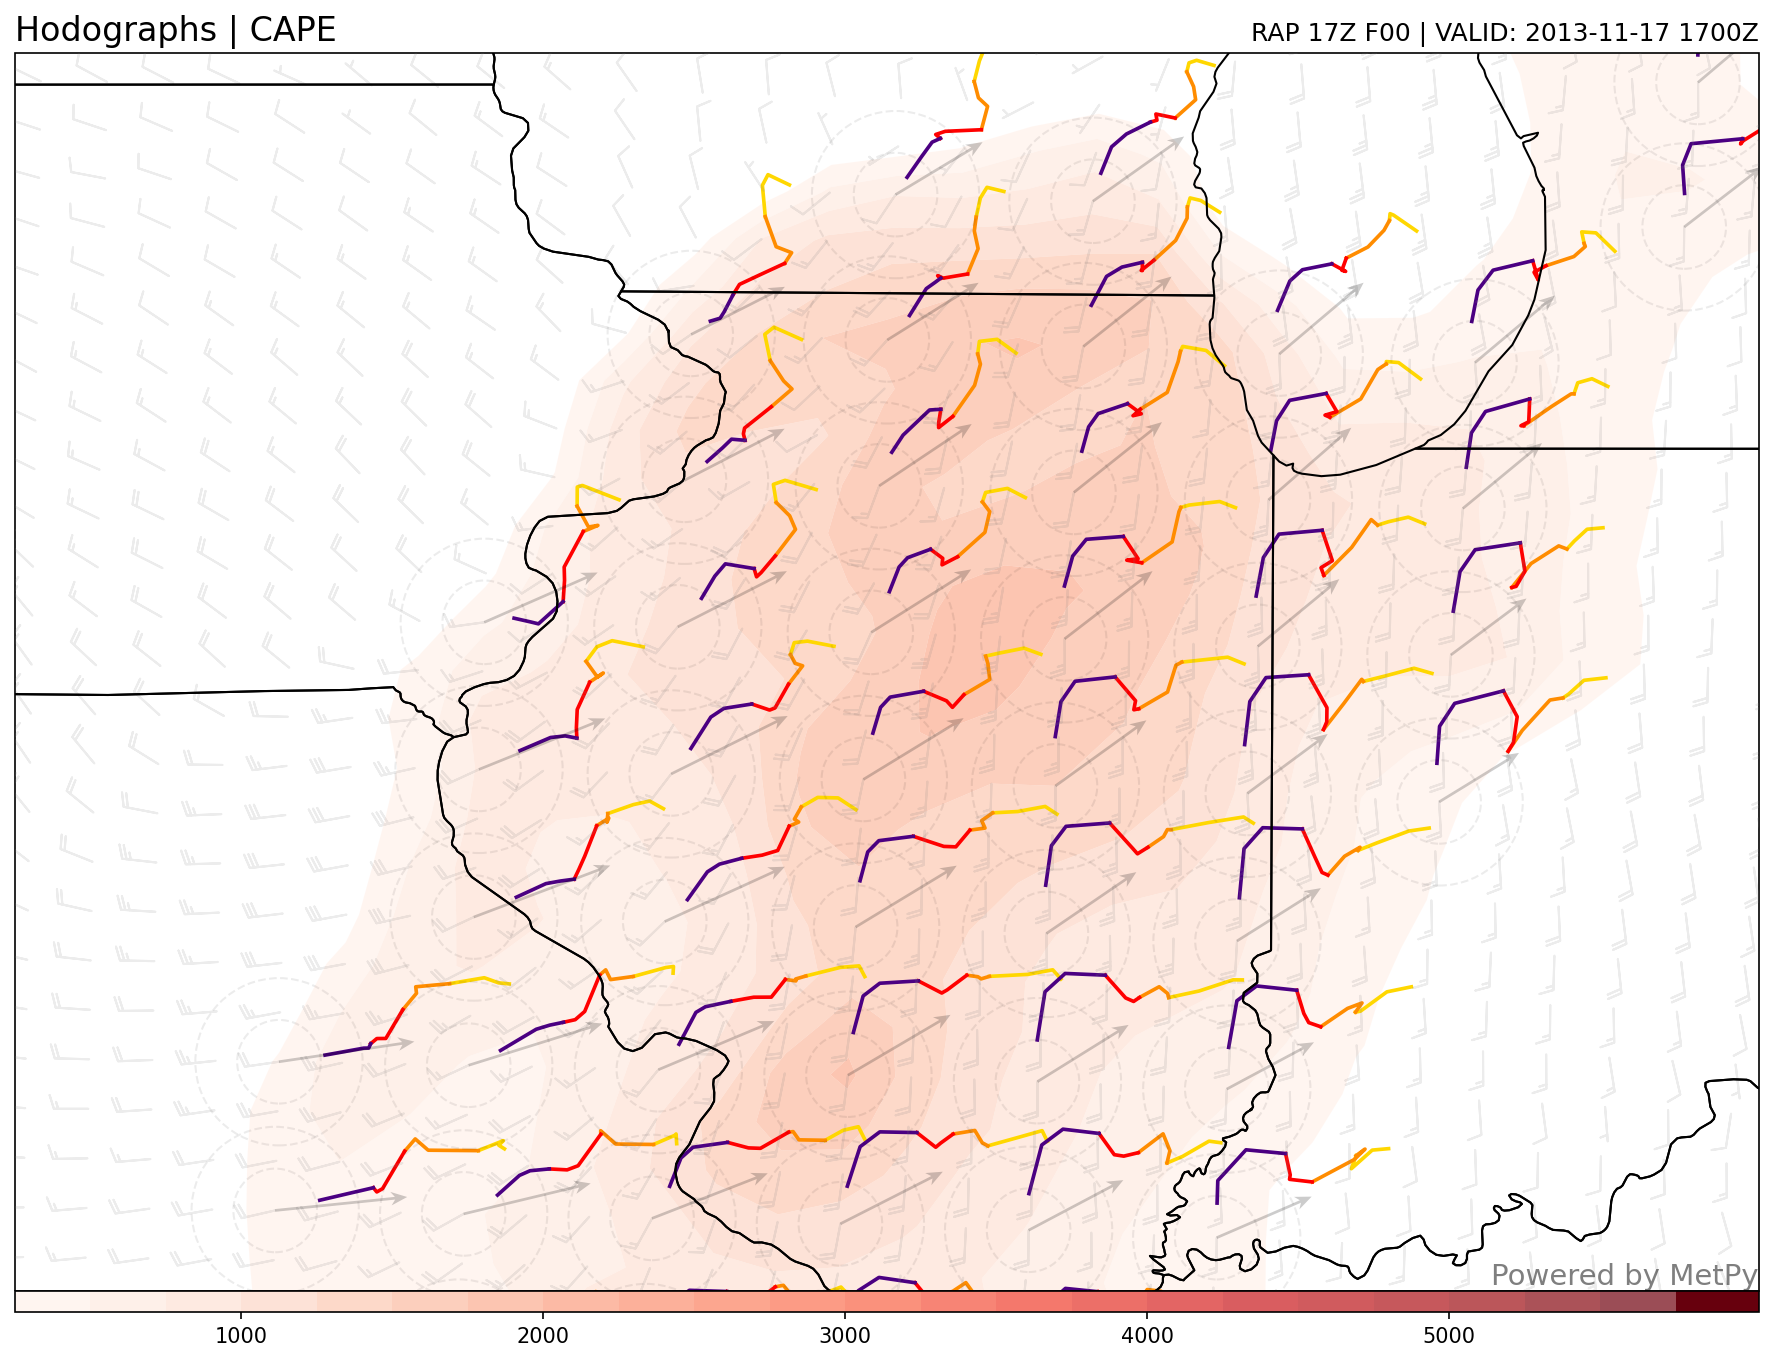

In [8]:
%matplotlib inline
from matplotlib import ticker
    
fig=plt.figure(1,figsize=(15,12),dpi=150)
fig.patch.set_facecolor('white')
ax = plt.subplot(111,projection=crs)
# Limit the extent of the map area, must convert to proper coords.
LL = crs.transform_point((west_lon + 0.5),(north_lat - 0.34),ccrs.PlateCarree())
UR = crs.transform_point((east_lon - 0.5),(south_lat + 0.34),ccrs.PlateCarree())
ax.set_extent([LL[0],UR[0],LL[1],UR[1]],crs)

ax.add_feature(states_provinces,edgecolor='black',linewidth=1.0, zorder=4.4)

# Plot CAPE
# Filled color contours
caperange = np.arange(250,6000,250)
cf = ax.contourf(tlons[::res,::res],tlats[::res,::res],cape[::res,::res],caperange,cmap=plt.cm.Reds,extend='max',alpha=0.7,antialiased=True)
cbar = plt.colorbar(cf,orientation='horizontal',ticks=[1000,2000,3000,4000,5000],fraction=.0178,aspect=82,pad=0,extendrect='False')
cbar.ax.set_xticklabels(['1000','2000','3000','4000','5000'])

# Plot SRH
# Contours
# cs = ax.contour(tlons[::res,::res],tlats[::res,::res],ndimage.gaussian_filter(srh3[::res,::res],sigma=1),range(100,200,50),colors='deepskyblue',linewidths=1,alpha=0.9,antialiased=True)
# plt.clabel(cs,fontsize=10,inline=1,inline_spacing=10,fmt='%i',rightside_up=True,use_clabeltext=True)
# cs = ax.contour(tlons[::res,::res],tlats[::res,::res],ndimage.gaussian_filter(srh3[::res,::res],sigma=1),range(200,300,50),colors='dodgerblue',linewidths=2,alpha=0.9,antialiased=True)
# plt.clabel(cs,fontsize=10,inline=1,inline_spacing=10,fmt='%i',rightside_up=True,use_clabeltext=True)
# cs = ax.contour(tlons[::res,::res],tlats[::res,::res],ndimage.gaussian_filter(srh3[::res,::res],sigma=1),range(300,1800,50),colors='navy',linewidths=2,alpha=0.9,antialiased=True)
# plt.clabel(cs,fontsize=10,inline=1,inline_spacing=10,fmt='%i',rightside_up=True,use_clabeltext=True)

plot_hodomap(u,v,rightmoveru,rightmoverv,tlons,tlats,ax,scaling=0.01,spacing=3)


plt.scatter(-100.74,32.61,s=30,color='black')

# Titles
ax.text(1, 0, 'Powered by MetPy',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,color='black', fontsize=14,zorder=5,alpha=0.5)
if (relativity == 'storm'):
    plt.title('Storm-Relative Hodographs | CAPE',loc='left', fontsize=16)
else:
    plt.title('Hodographs | CAPE',loc='left', fontsize=16)
plt.title(str(model)+' '+str(hour[0:2])+'Z F'+str(fcst[0:2])+' | VALID: ' +(vtimes[0].strftime('%Y'))+'-'+(vtimes[0].strftime('%m'))+'-'+(vtimes[0].strftime('%d'))+' '+(vtimes[0].strftime('%H00'))+'Z',loc='right')